# Optimisation: Using Transformed Parameters

This example shows you how to run a global optimisation with a transformed parameter space.


First we will create a toy model which implements the logistic model.

In [5]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl
import math

model = toy.LogisticModel()

The parameters for the toy logistic model are $[r, K]$, where $r$ is the rate and $K$ is the carrying capacity. We will create a wrapper pints model that assumes that the parameters are given as $(r, \log(K)]$

In [6]:
class TransformedModel(pints.ForwardModel):
    def __init__(self, model):
        self._model = model
    def dimension(self):
        return self._model.dimension()
    def simulate(self, parameters, times):
        transformed_parameters = [parameters[0],math.exp(parameters[1])]
        return self._model.simulate(transformed_parameters,times)

transformed_model = TransformedModel(model)

Now that we have our transformed model, we can use it in combination with all of pints' optimisation and inference algorithms. For now, we will use it to fit simulated data using CMA-ES:

Population size 8
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 2 (seed=885071, Tue Jan 23 12:21:04 2018)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.483658366921819e+07 1.0e+00 1.18e-02  1e-02  1e-02 0:00.0
    2     16 3.457529456545197e+07 1.4e+00 1.46e-02  1e-02  2e-02 0:00.0
    3     24 3.467748840943466e+07 2.1e+00 1.72e-02  2e-02  2e-02 0:00.0
  100    800 9.205442081373440e+04 6.7e+01 1.61e-02  2e-06  1e-04 0:00.5
  162   1296 9.205412074769035e+04 5.3e+00 2.34e-06  2e-12  8e-12 0:00.8
termination on tolx=1e-11
final/bestever f-value = 9.205412e+04 9.205412e+04
incumbent solution: [0.014974077421399631, 5.9998703069370141]
std deviation: [1.6140920155391298e-12, 8.335623992882847e-12]
Score at true solution: 
92225.2185915
Found solution:          True parameters:
 1.49740774194689584e-02     1.49999999999999994e-02
 5.99987030705613567e+00     6.00000000000000000e+00


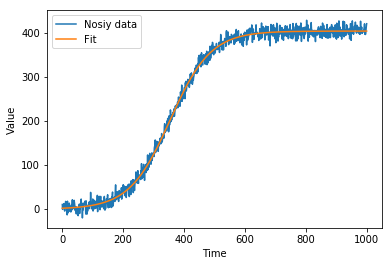

In [7]:
# Create some toy data
real_parameters = [0.015, 6]
times = np.linspace(0, 1000, 1000)
values = transformed_model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(transformed_model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.Boundaries([0, -6.0], [0.03, 20.0])

# Perform an optimization with boundaries and hints
x0 = 0.01,5.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.cmaes(
    score,
    boundaries,
    x0,
    sigma0,
    )

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
pl.figure()
pl.xlabel('Time')
pl.ylabel('Value')
pl.plot(times, values, label='Nosiy data')
pl.plot(times, problem.evaluate(found_parameters), label='Fit')
pl.legend()
pl.show()